In [1]:
import numpy as np
from scipy.linalg import khatri_rao
import matplotlib.pyplot as plt

## Tensor unfolding 
Mode-0, Mode-1, Mode-2 Unfolding

In [2]:
class unfold_Tensor():
    def mode_zero_unfold(self, tensor):
        new_matrix = tensor[0]
        number, _, _ = tensor.shape
        for i in range(1, number):
             new_matrix = np.hstack((new_matrix, tensor[i]))
        return new_matrix

    def mode_one_unfold(self, tensor):
        new_matrix = tensor[0].T
        number, _, _ = tensor.shape
        for i in range(1, number):
             new_matrix = np.hstack((new_matrix, tensor[i].T))
        return new_matrix

    def mode_two_unfold(self, tensor):
        new_matrix = tensor[0].T.flatten()
        number, _, _ = tensor.shape
        for i in range(1, number):
            new_matrix = np.vstack((new_matrix, tensor[i].T.flatten()))
        return new_matrix

    def tensor_unfold(self, tensor, mode):
        unfold_tensor = None
        if mode == 0:
            unfold_tensor = self.mode_zero_unfold(tensor)
        elif mode == 1:
            unfold_tensor = self.mode_one_unfold(tensor)
        elif mode == 2:
            unfold_tensor = self.mode_two_unfold(tensor)
        else:
            print("Wrong mode value please enter mode between 0, 1 and 2 only.")
        return unfold_tensor

In [3]:
A = np.array([[[0, 2, 4, 6], [8, 10, 12, 14], [16, 18, 20, 22]], 
              [[1, 3, 5, 7], [9, 11, 13, 15], [17, 19, 21, 23]]])
u = unfold_Tensor()
print("Tensor [frontal slices]: ")
print(A)
print()
X_0 = u.tensor_unfold(A, 0)
print("Mode-0 unfolding...")
print(X_0)
print()
X_1 = u.tensor_unfold(A, 1)
print("Mode-1 unfolding...")
print(X_1)
print()
X_2 = u.tensor_unfold(A, 2)
print("Mode-2 unfolding...")
print(X_2)

Tensor [frontal slices]: 
[[[ 0  2  4  6]
  [ 8 10 12 14]
  [16 18 20 22]]

 [[ 1  3  5  7]
  [ 9 11 13 15]
  [17 19 21 23]]]

Mode-0 unfolding...
[[ 0  2  4  6  1  3  5  7]
 [ 8 10 12 14  9 11 13 15]
 [16 18 20 22 17 19 21 23]]

Mode-1 unfolding...
[[ 0  8 16  1  9 17]
 [ 2 10 18  3 11 19]
 [ 4 12 20  5 13 21]
 [ 6 14 22  7 15 23]]

Mode-2 unfolding...
[[ 0  8 16  2 10 18  4 12 20  6 14 22]
 [ 1  9 17  3 11 19  5 13 21  7 15 23]]


## CANDECOMP/PARAFAC Decomposition:

In [4]:
def reconstruct_estimation_tensor(a, b, c, input_shape):
    M = np.zeros(input_shape)
    if a.shape[1] == b.shape[1] == c.shape[1]:
        pass
    else:
        print("Columns of a, b, c matrices must be equal")
        return None
    for col_index in range(0, a.shape[1]):
        a_tilde = np.asarray([a[:, col_index]]).T
        b_tilde = np.asarray([b[:, col_index]]).T
        c_tilde = np.asarray([c[:, col_index]]).T
        result_1 = khatri_rao(a_tilde, b_tilde)
        result_2 = khatri_rao(result_1,c_tilde)
        result_2 = np.reshape(result_2, input_shape)
        M += result_2
    return M
        
def CP_Decomposition(tensor, rank, max_iter):
    error = []
    u = unfold_Tensor()
    a = np.random.random((rank, tensor.shape[0]))
    b = np.random.random((rank, tensor.shape[1]))
    c = np.random.random((rank, tensor.shape[2]))

    for epoch in range(max_iter):
        input_a = khatri_rao(b.T, c.T)
        target_a = u.tensor_unfold(tensor, mode=2).T
        a = np.linalg.solve(input_a.T.dot(input_a), input_a.T.dot(target_a))
        input_b = khatri_rao(a.T, c.T)
        target_b = u.tensor_unfold(tensor, mode=0).T
        b = np.linalg.solve(input_b.T.dot(input_b), input_b.T.dot(target_b))
        input_c = khatri_rao(a.T, b.T)
        target_c = u.tensor_unfold(tensor, mode=1).T
        c = np.linalg.solve(input_c.T.dot(input_c), input_c.T.dot(target_c))
        M = reconstruct_estimation_tensor(a.T, b.T, c.T, tensor.shape)
        sse_error = (np.linalg.norm((tensor-M)))**2
        error.append(sse_error)
        if epoch %100 == 0:
            print("Epoch: ",epoch, "Sum of squared error: ", sse_error)
    return a.T, b.T, c.T, error

In [5]:
input_shape = (3, 6, 5)
A = np.random.random(input_shape)
max_iter = 300
a, b, c, error = CP_Decomposition(A, 3, max_iter)

Epoch:  0 Sum of squared error:  5.848011599656308
Epoch:  100 Sum of squared error:  5.14199242119372
Epoch:  200 Sum of squared error:  5.147657302888952


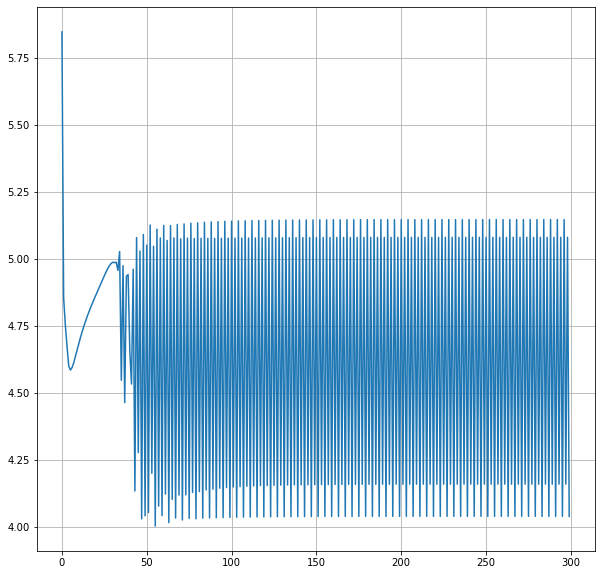

In [6]:
M = reconstruct_estimation_tensor(a, b, c, input_shape)
plt.figure(figsize=(10, 10))
plt.plot(error)
plt.grid()
plt.show()

In [7]:
print("Difference between original and reconstructed matrix")
print(A-M)

Difference between original and reconstructed matrix
[[[ 0.44019855 -0.17834065 -0.27405193 -0.22370904 -0.41016871]
  [ 0.16957092  0.22556486  0.16981283 -0.23625609 -0.17397093]
  [-0.18815188  0.34838089  0.14643459  0.03530524 -0.10954222]
  [ 0.18100436  0.01414797 -0.04142137  0.01003456 -0.0343831 ]
  [-0.03528551  0.0049994   0.02497131  0.33955522 -0.02518293]
  [-0.03035513 -0.07795897  0.09898704 -0.10047451  0.09582   ]]

 [[-0.28871733 -0.12196428 -0.0518664  -0.13293202 -0.12022441]
  [ 0.08009665  0.22189741  0.05646049 -0.1418864   0.27419214]
  [-0.08515707 -0.02599844  0.14377483  0.14912878  0.00198699]
  [ 0.30885677 -0.2390407  -0.06374304  0.07334156  0.45251342]
  [ 0.35660369 -0.31755422  0.51834462  0.18050846 -0.20506246]
  [-0.24682462  0.01470833  0.05440177 -0.11815268  0.00552055]]

 [[ 0.2143241   0.19724984 -0.20986729  0.49272961  0.18001521]
  [-0.38520216 -0.1035989  -0.21500528  0.30412753 -0.08548563]
  [ 0.00935839  0.0013515   0.09178825 -0.34095